<h1> SGWB Phase Space Analysis</h1> 

In the following, we'll implement a notebook that, given the required Probability Distribution Functions (PDF) describing a Black Hole population(BH), generates the figure of merit for the predicted analytical Stochastic Gravitational Wave Background(SGWB) in function of the amplitude and redshift range of the merging rate.
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("seaborn-v0_8-whitegrid")

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Merger distribution parameters

T_obs = 4. # Lisa estimated years of observation
efficiency = 1. # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
MPc = 3.08567758149137*1e22 # meters
GPc = MPc*1e3 # meters
h = 0.678
H_0 = 67.8*1e3/MPc # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 10
frq_res = 1e-6
frq_prec = int((frq_max - frq_min)/frq_res) + 1


<h2> Utility functions </h2>

In the following, we are going to define some useful generical functions that will be needed to present the results.
We will start with a function that can be used to convert matplotlib contour line to arrays.

In [3]:
def get_contour_verts(cn):
    # Given a set of contour line, save them as a dictionary
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

<h2> Loading the precomputed dataset </h2>

Once the main software has run, the precoumputed datasets for the conversion map can be loaded using the pickle commands :

In [4]:
LogNormalFileToRead = open("ConvMapLNPDF.pickle", "rb")
LogNormalMap = pickle.load(LogNormalFileToRead)
GaussianFileToRead = open("ConvMapGSPDF.pickle", "rb")
GaussianMap = pickle.load(GaussianFileToRead)

<h2> Estimating the figure of merit grid values </h2>

The values estimated on the previous subsection, now need to be spanned over the phase space in order to plot the figure of merits in function of the parameters. Let's start by initializing the grid:

In [5]:
# Common Parameters

PBH_m = 2.5 # Solar Masses. Minimum value assumed for the PBH mass
PBH_M = 100. # Solar Masses. Maximum value assumed for the PBH mass
PBH_frange = np.logspace(-3.,0.,100)
app = np.linspace(0, 100., 100)
PBH_pdfmspan = np.linspace(0, 1., len(app) -1) # this span will be needed to compute the figures of merit
PBH_pdfmspan = 0.5*(app[1::] + app[:-1:]) # We are gonna build the span by finding the mid point of the normal span
X = {}
Y = {}

#LogNormal Parameters

PBH_LNsigmaspan = [0.1 ,0.5 ,1. , 2.5] # Values of sigma_m to be spanned by the simulation

# Gaussian Parameters

PBH_GSsigmaspan = [1. ,5. ,10. ,15.] # Values of sigma_m to be spanned by the simulation
    
# Creating the grid 

for i in range(len(PBH_LNsigmaspan)):
    X[i], Y[i] = np.meshgrid(PBH_pdfmspan, PBH_frange)

<h2> Plotting the results </h2>

Given the spectrum in omega units, we can proceed to plot our results.
However, let's run this additional script that would increase the font size for the plots :

In [6]:
%run BigFont.py 

<h3> Plots for the PBH perturbation case </h3>

In the case of a PBH perturbation, we can now plot the figure of merit as follows :

<h4> Results for aplus LIGO </h4>

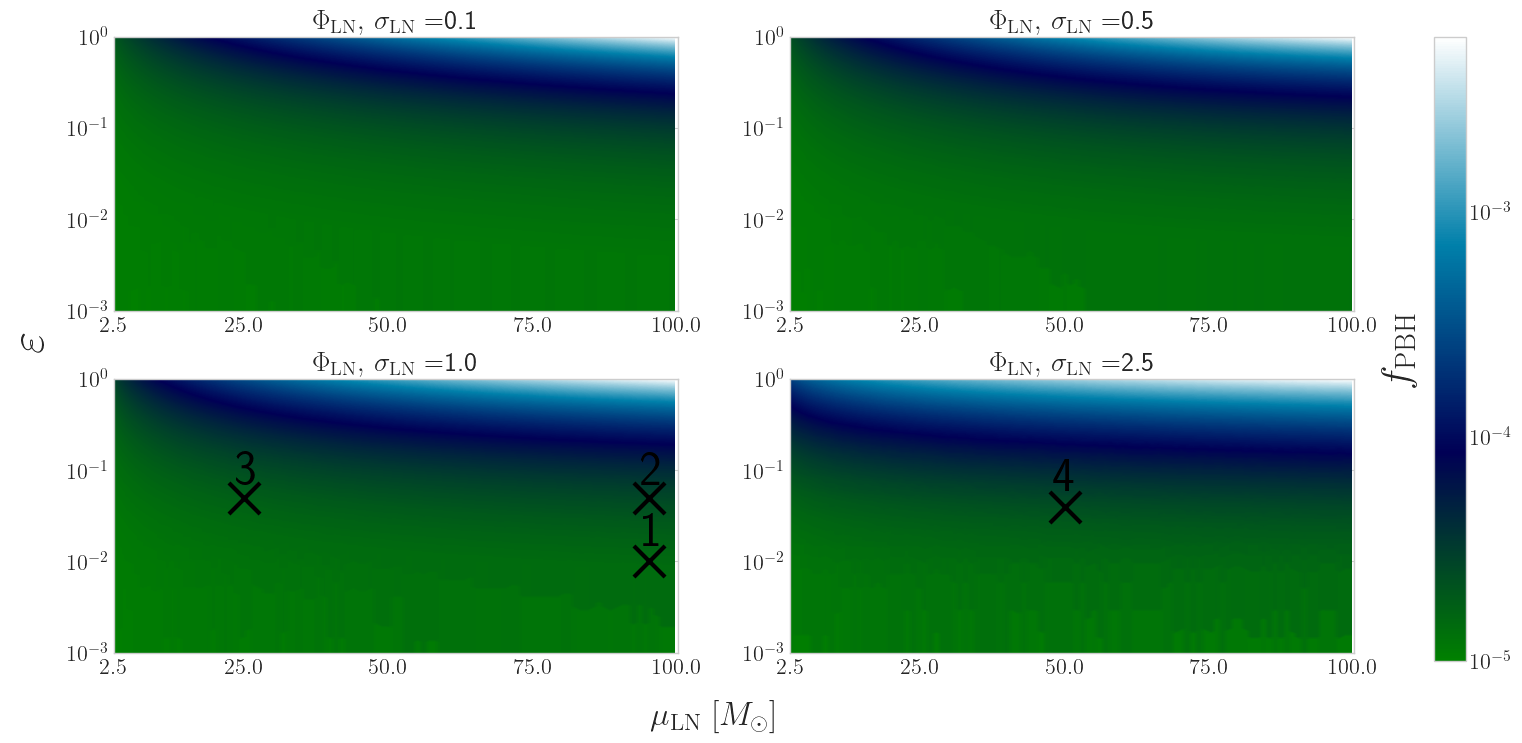

In [7]:
fig, ax = plt.subplots(figsize = [16,8], nrows = 2, ncols = 2)
plt.subplots_adjust(wspace = 0.2, hspace = 0.25)
idx = 0
cax = plt.axes([0.95, 0.1, 0.02, 0.78])
norm = mpl.colors.LogNorm(vmin=1.e-05, vmax=0.006)
clb = mpl.colorbar.ColorbarBase(cax, cmap= 'ocean', norm=norm)
clb.set_label(label=r'$f_{\rm PBH}$', rotation = 90,labelpad=-95, y= 0.5, fontsize=30)

for i in range(2):
    for j in range(2):
            contf = ax[i][j].contourf(X[idx], Y[idx], LogNormalMap[idx], 500, cmap='ocean')
            ax[i][j].set_ylim(1e-3,1.)
            ax[i][j].set_yscale('log')
            ax[i][j].set_xlim(2.5,100.)
            ax[i][j].set_xticks([2.5,25., 50., 75., 100.])
            ax[i][j].set_title(r'$ \Phi_{\rm LN}, \,  \sigma_{\rm LN} = $' + str(PBH_LNsigmaspan[idx]), fontsize = 20)
            idx += 1
            
# Plotting the benchmark points on the parameter space
ax[1][0].scatter(95., 0.01, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][0].text(94., 0.015, "1", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
ax[1][0].scatter(95., 0.05, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][0].text(93.5, 0.07, "2", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
ax[1][0].scatter(25., 0.05, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][0].text(23.5, 0.07, "3", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
ax[1][1].scatter(50., 0.04, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][1].text(48, 0.06, "4", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
fig.text(0.06, 0.5, r'$\varepsilon$', va = 'center', rotation='vertical', fontsize = 35)
fig.text(0.5, 0.02, r'$\mu_{\rm LN} \; [M_\odot]$', ha = 'center', fontsize = 24)
   
fname = 'LogNormalConvMap.png'
   
fig.savefig(fname, dpi = 200)
#fig.savefig(fname, dpi = 50)

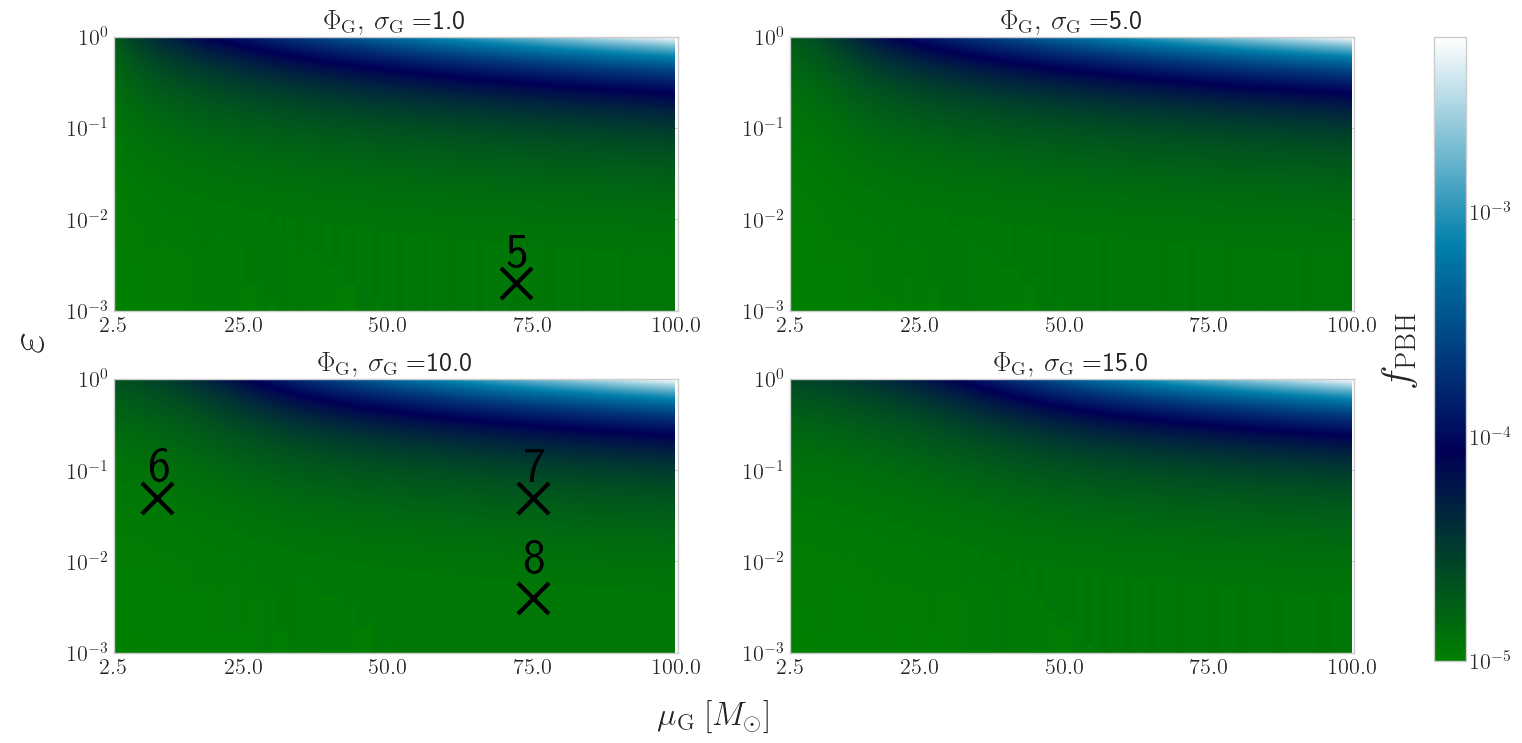

In [8]:
fig, ax = plt.subplots(figsize = [16,8], nrows = 2, ncols = 2)
plt.subplots_adjust(wspace = 0.2, hspace = 0.25)
idx = 0
cax = plt.axes([0.95, 0.1, 0.02, 0.78])
norm = mpl.colors.LogNorm(vmin=1.e-05, vmax=0.006)
clb = mpl.colorbar.ColorbarBase(cax, cmap= 'ocean', norm=norm)
clb.set_label(label=r'$f_{\rm PBH}$', rotation = 90,labelpad=-95, y= 0.5, fontsize=30)

for i in range(2):
    for j in range(2):
            contf = ax[i][j].contourf(X[idx], Y[idx], GaussianMap[idx], 500, cmap='ocean')
            ax[i][j].set_ylim(1e-3,1.)
            ax[i][j].set_yscale('log')
            ax[i][j].set_xlim(2.5,100.)
            ax[i][j].set_xticks([2.5,25., 50., 75., 100.])
            ax[i][j].set_title(r'$\Phi_{\rm G}, \, \sigma_{\rm G} = $' + str(PBH_GSsigmaspan[idx]) , fontsize = 20 )
            idx += 1
            
# Plotting the benchmark points on the parameter space
ax[0][0].scatter(72., 0.002, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[0][0].text(70.5, 0.003, "5", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
ax[1][0].scatter(10., 0.05, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][0].text(8.5, 0.075, "6", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
ax[1][0].scatter(75., 0.05, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][0].text(73.5, 0.075, "7", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
ax[1][0].scatter(75., 0.004, color = 'black', marker = 'x', s = 500, linewidths=3)
ax[1][0].text(73.5, 0.0075, "8", horizontalalignment='left', fontsize=35, color='black', weight='semibold')
fig.text(0.06, 0.5, r'$\varepsilon$', va = 'center', rotation='vertical', fontsize = 35)
fig.text(0.5, 0.02, r'$\mu_{\rm G} \; [M_\odot]$', ha = 'center', fontsize = 24)
    
fname = 'GaussianConvMap.png'

fig.savefig(fname, dpi = 200)
#fig.savefig(fname, dpi = 50)